In [77]:
%matplotlib inline
import numpy as np
%load_ext autoreload
%autoreload 2

#plot library
import seaborn as sns
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
from helpers import *
from cross_val import *
from preprocessing import *
from plot import *


# Data exploration

In [79]:
DEBUG = False 

In [80]:
PATH_TRAIN= '../data/train.csv'
PATH_TEST = '../data/test.csv'
y, tX, ids = load_csv_data(PATH_TRAIN, sub_sample=DEBUG)
y_test, tX_test, ids_test = load_csv_data(PATH_TEST, sub_sample=DEBUG)
features_name = np.genfromtxt('../data/train.csv', delimiter=",", dtype=str,max_rows=1)[2:]

In [81]:
print("y train size : ", y.shape[0] )
print("train tX shape : ", tX.shape)
print( "y test size : ", y_test.shape[0])
print("test tX shape : ", tX_test.shape)

y train size :  250000
train tX shape :  (250000, 30)
y test size :  568238
test tX shape :  (568238, 30)


In [82]:
print("# Higgs signal particules (s): ", len(y[y==1]), '/',round(len(y[y==1])*100/len(y),0),'%')
print("# background particules (b): ", len(y[y==-1]), '/',round(len(y[y==-1])*100/len(y),0),'%')
print("There are" , len(tX[tX==-999.0]),'(',
      np.round(len(tX[tX==-999.0])*100./(len(tX)*30)),  "%), missing values")

# Higgs signal particules (s):  85667 / 34.0 %
# background particules (b):  164333 / 66.0 %
There are 1580052 ( 21.0 %), missing values


## Boxplot of the raw features

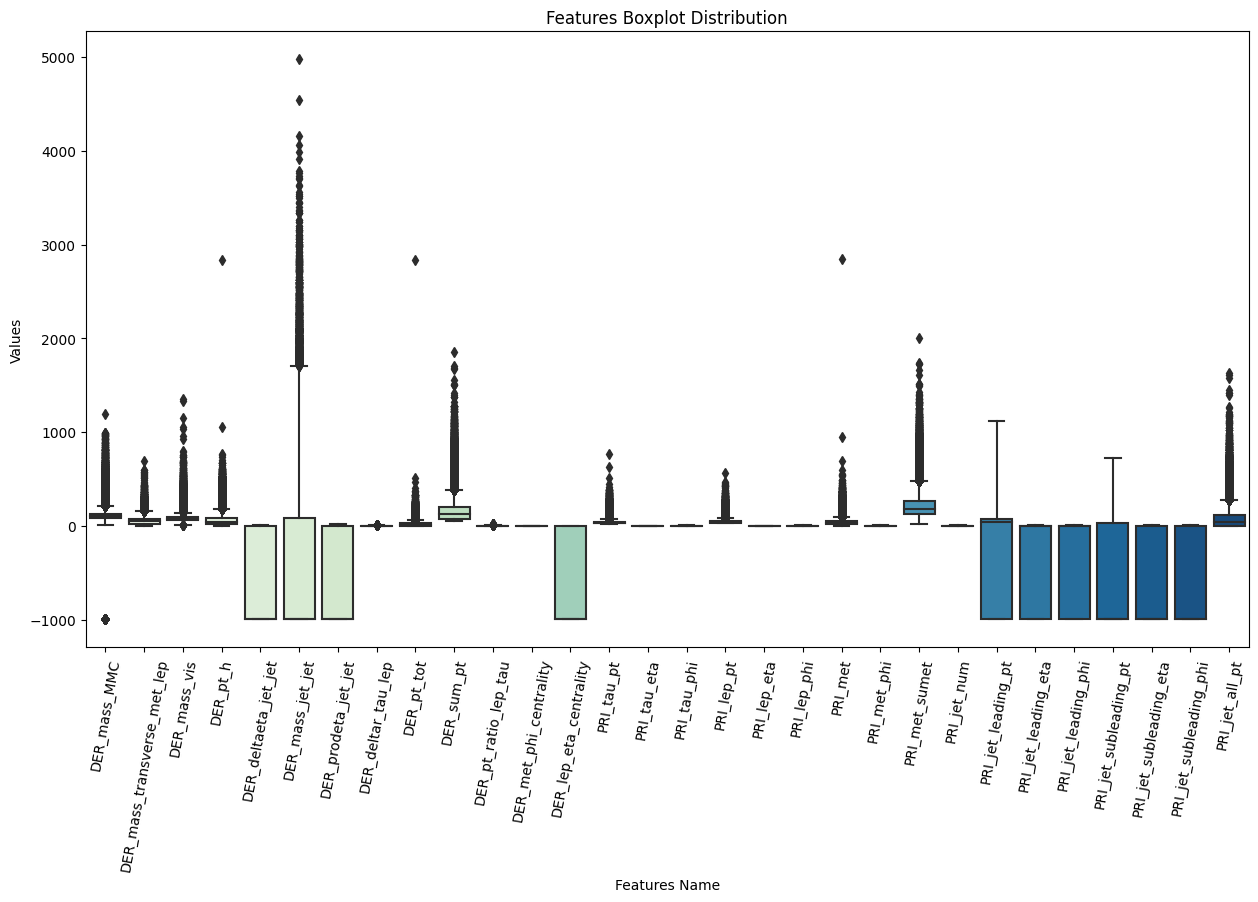

In [83]:
palette = sns.color_palette("GnBu", n_colors=30)

figure = plt.figure(figsize=(15,8))
ax = sns.boxplot(data = tX, palette = palette)
ax.set_xticklabels(features_name, rotation = 80)
plt.title("Features Boxplot Distribution")
plt.xlabel('Features Name')
plt.ylabel('Values')
plt.show()

## Distribution of all the raw features

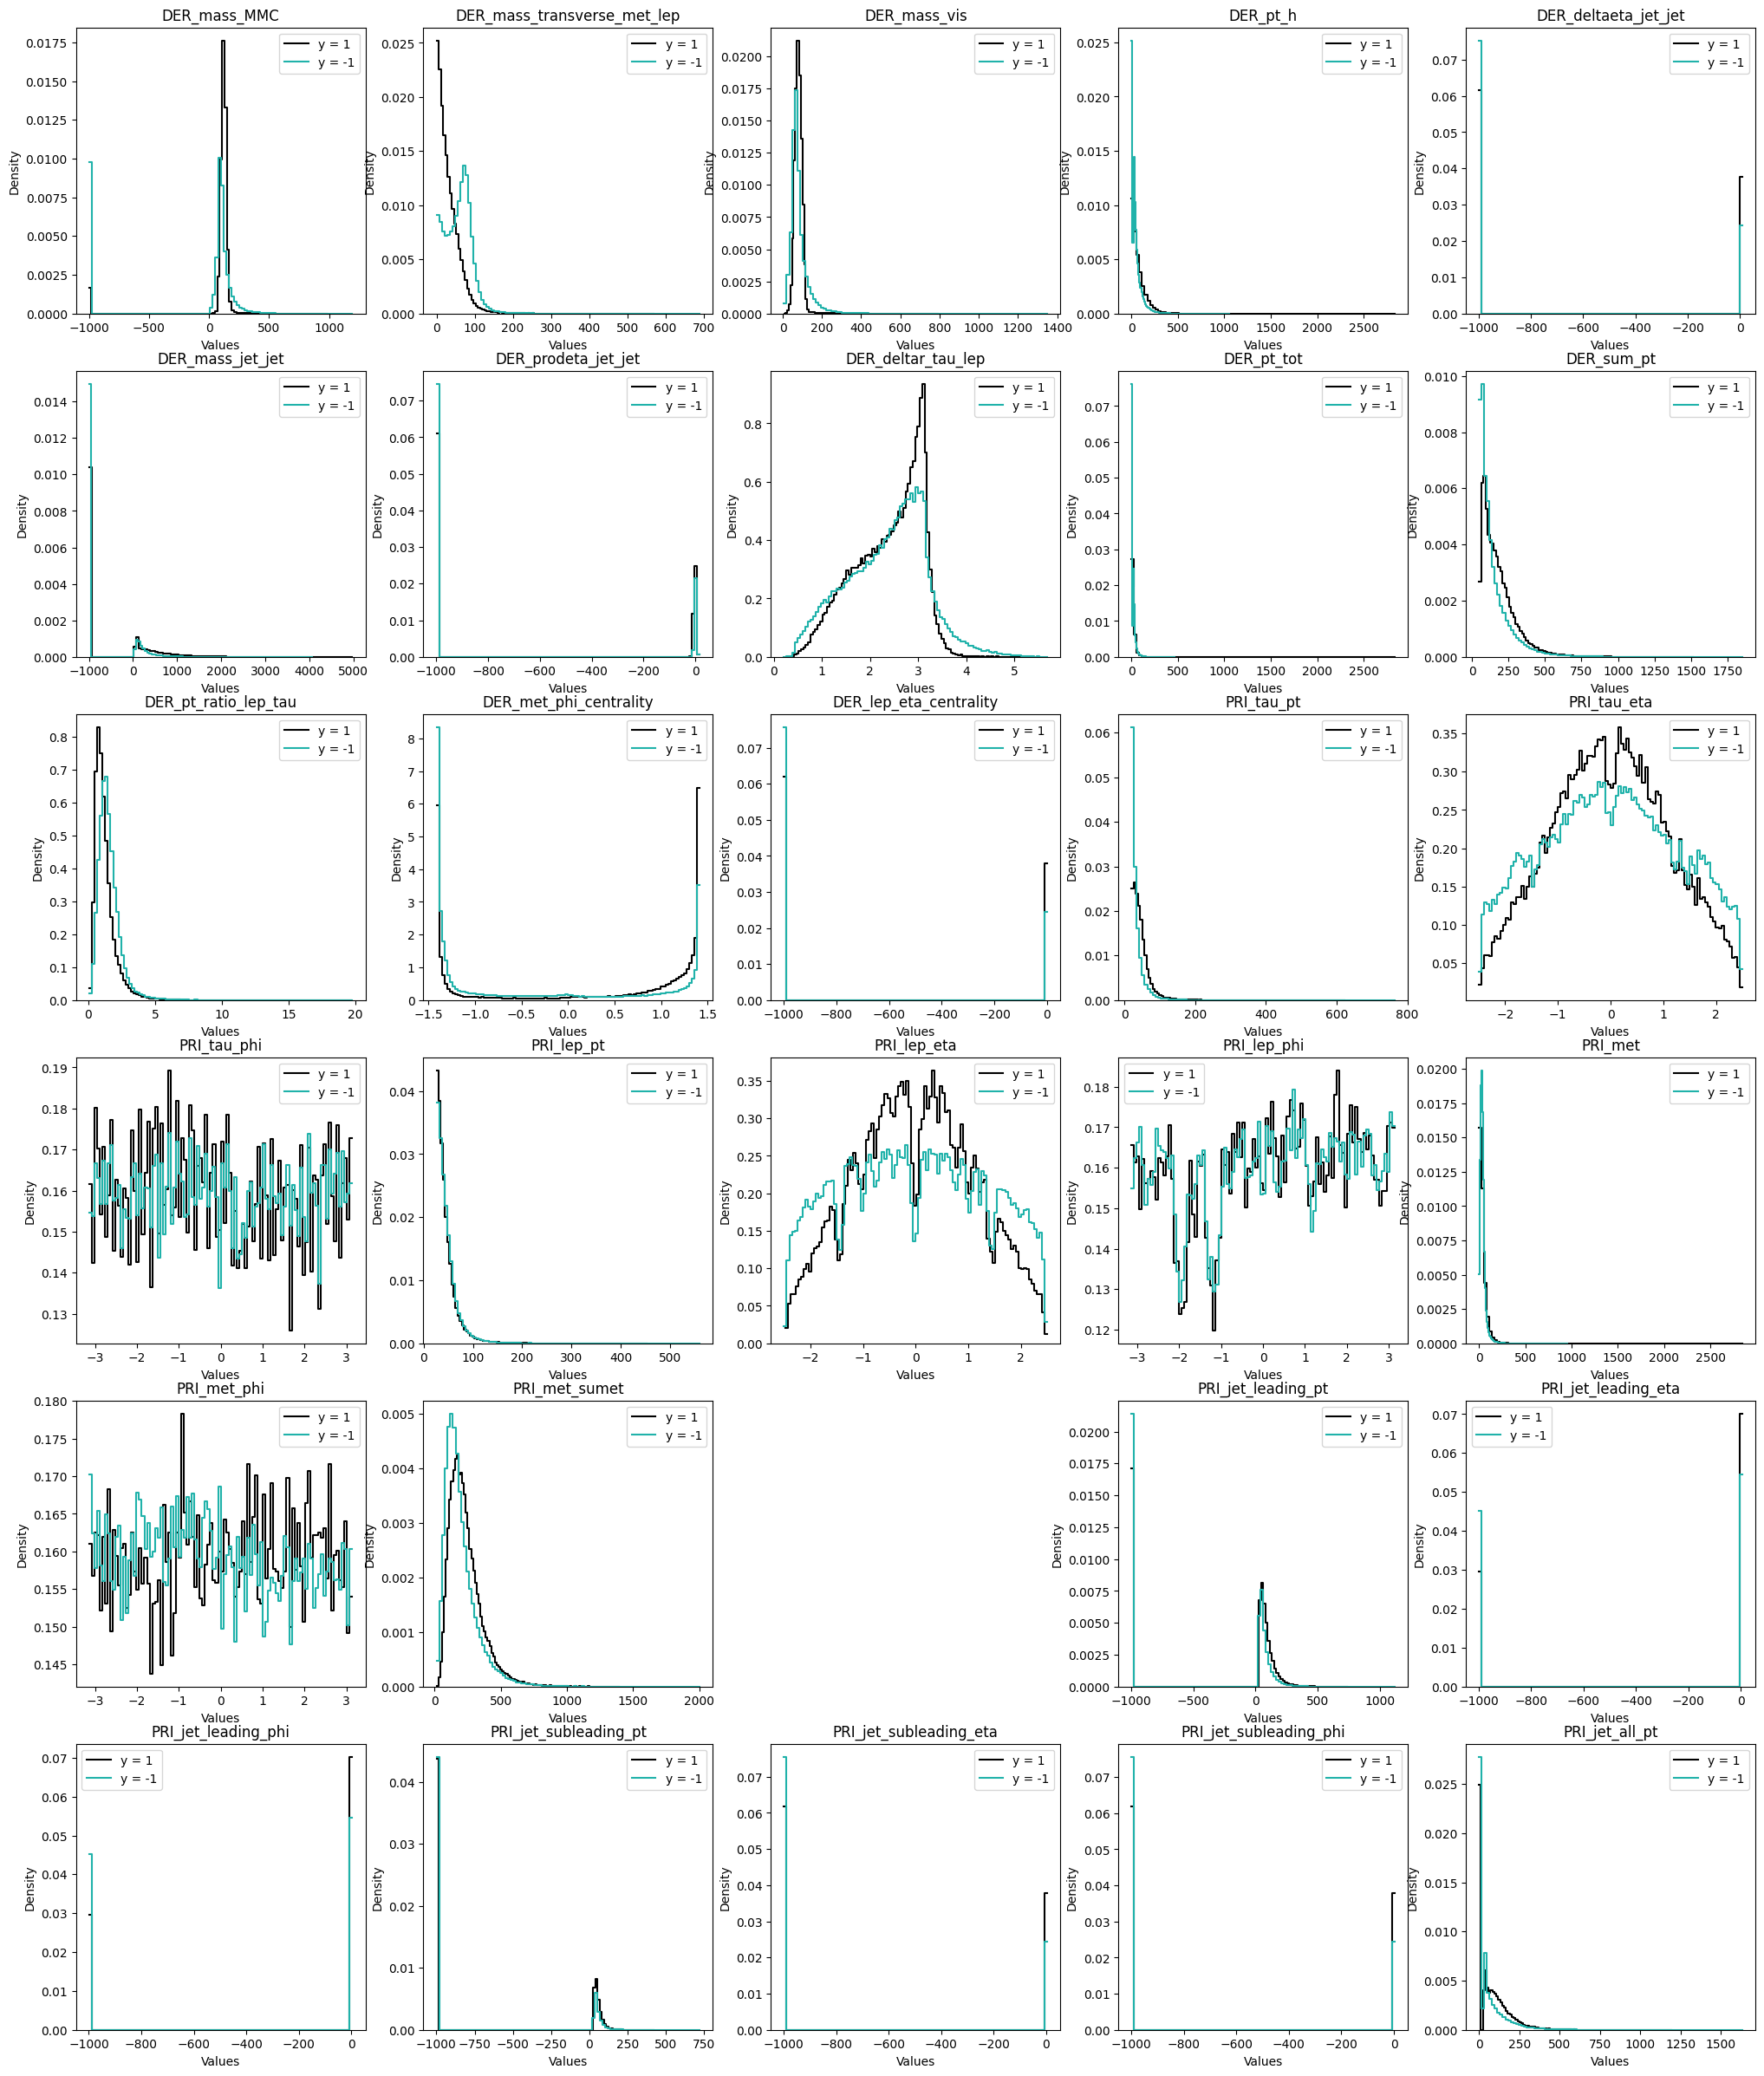

In [84]:
fig= plt.figure(figsize=(25,30))

for idx in range(tX.shape[1]):
    if idx == 22:
        # This is the jet num feature
        continue 
    ax=plt.subplot(6,5,idx+1)
    
    #density plot of each feature depending on the y response
    sns.histplot(data=tX[y==1, idx], ax=ax, element="step", 
                 fill=False, color = 'black', stat = 'density', bins = 100)
    sns.histplot(data=tX[y==-1, idx], ax=ax, element="step",
                 fill=False, color = 'lightseagreen', stat = 'density', bins = 100)
    
    #plot parameters
    ax.set_title(features_name[idx])
    ax.set_xlabel('Values')
    ax.legend(["y = 1", "y = -1"])
    
plt.show()

### Distribution of PRI_Jet_Num
There is only one categorical feature in the data set called PRI_JET_NUM. It indicates the number of jets per sample (0, 1, 2 or 3). Before getting into prediction, let's first observe the predictive power of this feature.

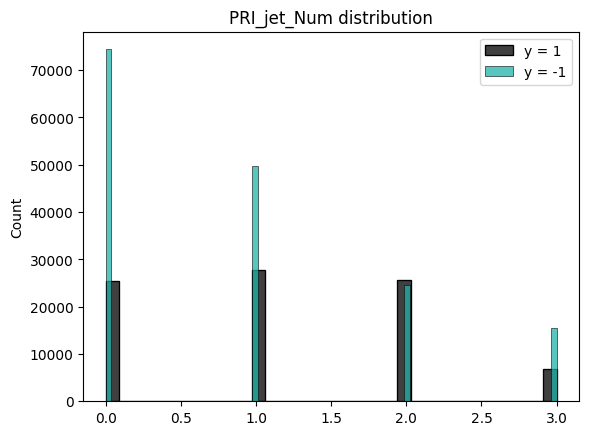

In [85]:
ax=plt.subplot(1,1, 1)
sns.histplot(tX[:,22][y==1], ax=ax, color='black')
sns.histplot(tX[:,22][y==-1],ax=ax,  color='lightseagreen')
ax.set_title("PRI_jet_Num distribution")
ax.legend(["y = 1", "y = -1"])
plt.show()

In [86]:
Jet_related_features = [ x for x in features_name if "jet" in x]
index_jet = [idx for idx, feat in enumerate(features_name) if "jet" in feat]
print('Features dependent on the Jet number : ')
for idx,feature in enumerate(Jet_related_features) : 
    print(feature, ' index : ',index_jet[idx])

Features dependent on the Jet number : 
DER_deltaeta_jet_jet  index :  4
DER_mass_jet_jet  index :  5
DER_prodeta_jet_jet  index :  6
PRI_jet_num  index :  22
PRI_jet_leading_pt  index :  23
PRI_jet_leading_eta  index :  24
PRI_jet_leading_phi  index :  25
PRI_jet_subleading_pt  index :  26
PRI_jet_subleading_eta  index :  27
PRI_jet_subleading_phi  index :  28
PRI_jet_all_pt  index :  29


## Baseline run, no jet separation

In [87]:
#Fixed Parameters 
seed = 1
k_fold = 10
max_iters = 100

In [88]:
preprocessed_X,preprocessed_X_test, preprocessed_y = preprocess_data(tX, tX_test, y, index_jet)

In [89]:
## Baseline
## Comparing all the methods with nothing done to rule out least squares GD and least squares SGD (since they are supposed to converge to least squares)
methods = [mean_squared_error_gd, mean_squared_error_sgd, least_squares, ridge_regression, logistic_regression, reg_logistic_regression]
params = [
    {'gamma': .01, 'degree': 1, 'cross': False, 'max_iters': max_iters}, # GD
    {'gamma': .01, 'degree': 1, 'cross': False, 'max_iters': max_iters}, # SGD
    {'degree': 1, 'cross': False}, # Least squares
    {'degree': 1, 'cross': False, 'lambda_':1e-4}, # Ridge regression
    {'gamma':1e-6, 'degree':1, 'cross':False, 'max_iters':max_iters, 'initial_w' : None}, # Logistic
    {'gamma':1e-6, 'degree':1, 'cross':False, 'lambda_': 0.01, 'max_iters':max_iters, 'initial_w':None}, # Reg Logistic
]


for i in range(len(methods)):
    log = True if 'logistic' in str(methods[i]) else False
    _, acc_val, _ = cross_tunning(preprocessed_y, preprocessed_X, k_fold=k_fold, method=methods[i], parameters=[params[i]], seed=seed,log=log)
    print((methods[i]).__name__)
    print('\033[1m' +'--> Test Accuracy: '+'\033[0m' , np.mean(acc_val), ' std ', np.std(acc_val)) 

mean_squared_error_gd
--> Test Accuracy:  0.7313543448163531  std  0.0027906196068164567
mean_squared_error_sgd
--> Test Accuracy:  0.6895594103754378  std  0.018274229171149185
least_squares
--> Test Accuracy:  0.7487213942503461  std  0.0031793607910027065
ridge_regression
--> Test Accuracy:  0.748705106279013  std  0.003168944542010076
logistic_regression
--> Test Accuracy:  0.743904226728561  std  0.0025791373863174724
reg_logistic_regression
--> Test Accuracy:  0.743904226728561  std  0.0025791373863174724


---

## Jet separation
From the above, we only keep LS and ridge regression for the study with jet separation

In [90]:
preprocessed_X, preprocessed_X_test, preprocessed_y, masks_test = preprocess_data_jet(tX, tX_test, y)

In [91]:
## Helpers

def cross_validation_visualization(param, acc_tr, acc_te, name_param):
    """Visualization the curves of acc_tr and acc_te."""
    
    plt.semilogx(param, acc_tr, marker=".", color='salmon', label='train error')
    plt.semilogx(param, acc_te, marker=".", color='lightblue', label='validation error')
    plt.xlabel(name_param)
    plt.ylabel("Accuracy")
    plt.title("Cross validation")
    plt.legend()
    plt.grid(True)
    

def print_param_test(params) : 
    """Display the set of parameters contained in the received argument params"""
    
    print('Tested parameters\n')
    for idx, param in enumerate(params): 
        print ('-', idx+1, 'th parameter tested : ', param, '\n')

In [92]:
# Big function to do the plots in the report
def make_analysis(x, y):
    res_for_plot_1 = {}
    res_for_plot_2 = {}
    
    ## -----------------------------------
    print('Least square - testing degrees')
    method = least_squares
    degree = [0, 4, 8, 10]
    parameters = []
    for d in degree:
        parameters.append({'degree':d, 'cross':False})
    print_param_test(parameters)
    acc_tr, acc_val, idx_best = cross_tunning(y, x, k_fold=k_fold, method=method, parameters=parameters, seed=seed)
    cross_validation_visualization(degree, np.mean(acc_tr, axis=1), np.mean(acc_val, axis=1), 'degree')
    plt.show()
    print('Best parameters\n', parameters[idx_best[0]], '\n')
    accuracy = np.mean(acc_val, axis = 1)[idx_best[0]]
    print('\033[1m' +'--> Test Accuracy for the best parameter : '+'\033[0m', accuracy)
    
    res_for_plot_1['baseline_LS'] = acc_val[0]
    res_for_plot_1['degree_LS'] = acc_val[-1]

    ## -----------------------------------
    print('Ridge regression - testing lambda for degree = 1')
    method = ridge_regression
    degree = 1
    lambdas = np.logspace(-8, 0, 9)
    parameters = []
    for l in lambdas:
        parameters.append({'degree':degree, 'cross':False, 'lambda_':l})
    print_param_test(parameters)
    acc_tr, acc_val, idx_best = cross_tunning(y, x, k_fold=k_fold, method=method, parameters=parameters, seed=seed)
    cross_validation_visualization(lambdas, np.mean(acc_tr, axis=1), np.mean(acc_val, axis=1), 'lambda')
    plt.show()
    print('Best parameters\n', parameters[idx_best[0]], '\n')
    accuracy = np.mean(acc_val, axis = 1)[idx_best[0]]
    print('\033[1m' +'--> Test Accuracy for the best parameter : '+'\033[0m', accuracy)

    res_for_plot_2['deg_0'] = np.mean(acc_val, axis = 1)

    print('Ridge regression - testing lambda for degree = 10')
    method = ridge_regression
    degree = 10
    lambdas = np.logspace(-8, 0, 9)
    parameters = []
    for l in lambdas:
        parameters.append({'degree':degree, 'cross':False, 'lambda_':l})
    print_param_test(parameters)
    acc_tr, acc_val, idx_best = cross_tunning(y, x, k_fold=k_fold, method=method, parameters=parameters, seed=seed)
    cross_validation_visualization(lambdas, np.mean(acc_tr, axis=1), np.mean(acc_val, axis=1), 'lambda')
    plt.show()
    print('Best parameters\n', parameters[idx_best[0]], '\n')
    accuracy = np.mean(acc_val, axis = 1)[idx_best[0]]
    print('\033[1m' +'--> Test Accuracy for the best parameter : '+'\033[0m', accuracy)
    
    res_for_plot_2['deg_10'] = np.mean(acc_val, axis = 1)

    ## -----------------------------------
    print('Least squares - testing cross term addition')
    method = least_squares
    parameters = [{'degree': 10, 'cross': True}]
    acc_tr, acc_val, _ = cross_tunning(y, x, k_fold=k_fold, method=method, parameters=parameters, seed=seed)
    res_for_plot_1['degree_cross_terms_LS'] = acc_val[0]
    print('Without cross terms')
    print(np.mean(res_for_plot_1['degree_LS']))
    print('With cross terms')
    print(np.mean(res_for_plot_1['degree_cross_terms_LS']))
    return res_for_plot_1, res_for_plot_2
    

Least square - testing degrees
Tested parameters

- 1 th parameter tested :  {'degree': 0, 'cross': False} 

- 2 th parameter tested :  {'degree': 4, 'cross': False} 

- 3 th parameter tested :  {'degree': 8, 'cross': False} 

- 4 th parameter tested :  {'degree': 10, 'cross': False} 



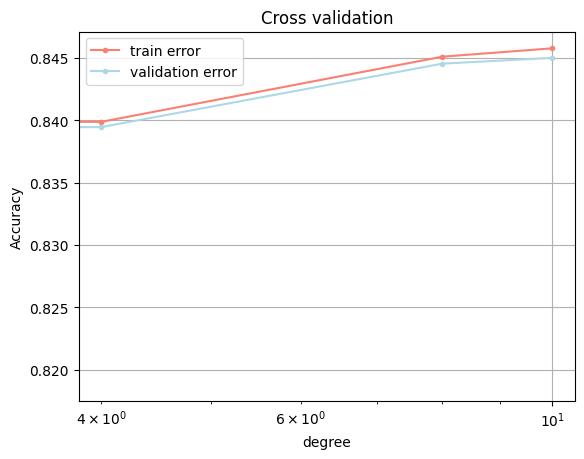

Best parameters
 {'degree': 10, 'cross': False} 

--> Test Accuracy for the best parameter :  0.8450136129877988
Ridge regression - testing lambda for degree = 1
Tested parameters

- 1 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 1e-08} 

- 2 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 1e-07} 

- 3 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 1e-06} 

- 4 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 1e-05} 

- 5 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 0.0001} 

- 6 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 0.001} 

- 7 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 0.01} 

- 8 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 0.1} 

- 9 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 1.0} 



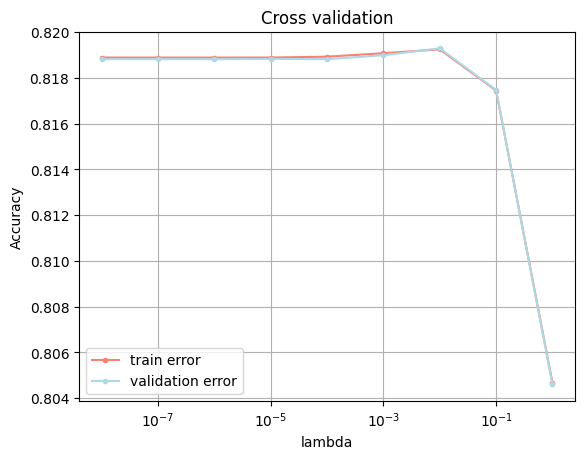

Best parameters
 {'degree': 1, 'cross': False, 'lambda_': 0.01} 

--> Test Accuracy for the best parameter :  0.819290107895533
Ridge regression - testing lambda for degree = 10
Tested parameters

- 1 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 1e-10} 

- 2 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 1e-09} 

- 3 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 1e-08} 

- 4 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 1e-07} 

- 5 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 1e-06} 

- 6 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 1e-05} 

- 7 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 0.0001} 

- 8 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 0.001} 

- 9 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 0.01} 

- 10 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 0.1} 

- 11 th parameter tested

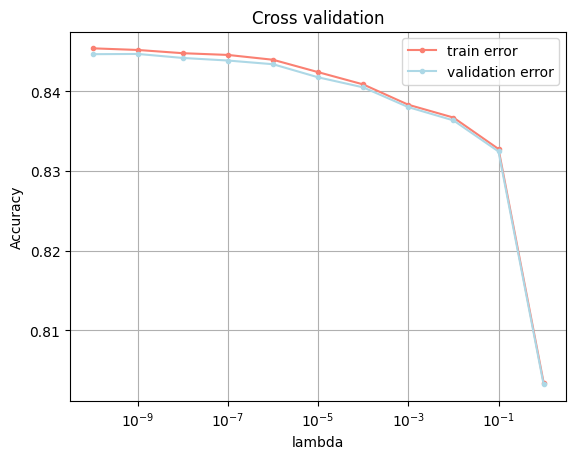

Best parameters
 {'degree': 10, 'cross': False, 'lambda_': 1e-09} 

--> Test Accuracy for the best parameter :  0.8447010184531611
Least squares - testing cross term addition
Without cross terms
0.8450136129877988
With cross terms
0.8476555409902188


In [93]:
plot1_group0, plot2_group0 = make_analysis(preprocessed_X['group_0'], preprocessed_y['group_0'])

Least square - testing degrees
Tested parameters

- 1 th parameter tested :  {'degree': 0, 'cross': False} 

- 2 th parameter tested :  {'degree': 4, 'cross': False} 

- 3 th parameter tested :  {'degree': 8, 'cross': False} 

- 4 th parameter tested :  {'degree': 10, 'cross': False} 



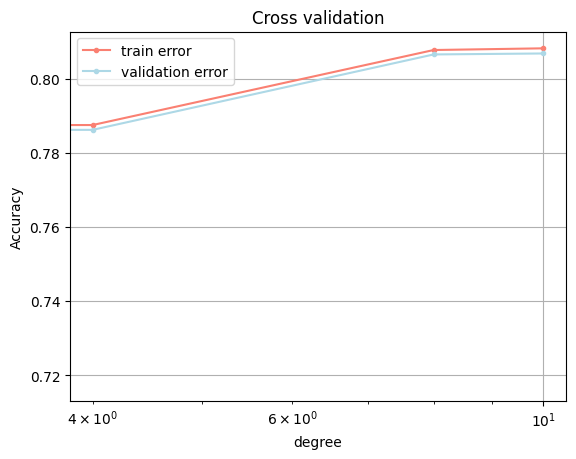

Best parameters
 {'degree': 10, 'cross': False} 

--> Test Accuracy for the best parameter :  0.8067687876407437
Ridge regression - testing lambda for degree = 1
Tested parameters

- 1 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 1e-08} 

- 2 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 1e-07} 

- 3 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 1e-06} 

- 4 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 1e-05} 

- 5 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 0.0001} 

- 6 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 0.001} 

- 7 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 0.01} 

- 8 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 0.1} 

- 9 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 1.0} 



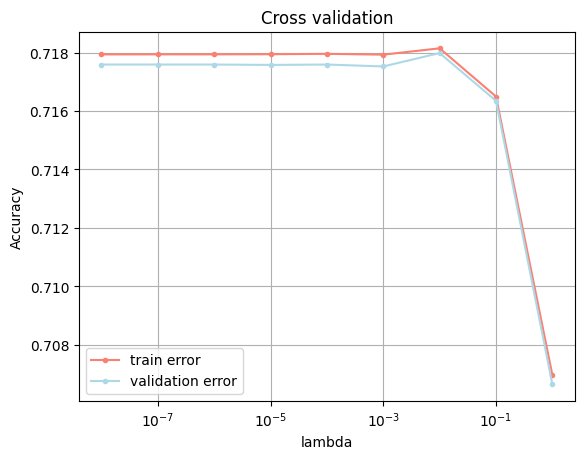

Best parameters
 {'degree': 1, 'cross': False, 'lambda_': 0.01} 

--> Test Accuracy for the best parameter :  0.717989002356638
Ridge regression - testing lambda for degree = 10
Tested parameters

- 1 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 1e-10} 

- 2 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 1e-09} 

- 3 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 1e-08} 

- 4 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 1e-07} 

- 5 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 1e-06} 

- 6 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 1e-05} 

- 7 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 0.0001} 

- 8 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 0.001} 

- 9 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 0.01} 

- 10 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 0.1} 

- 11 th parameter tested

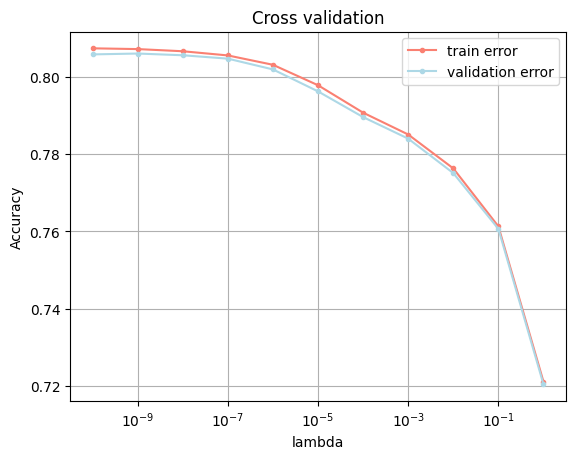

Best parameters
 {'degree': 10, 'cross': False, 'lambda_': 1e-09} 

--> Test Accuracy for the best parameter :  0.8059963341188793
Least squares - testing cross term addition
Without cross terms
0.8067687876407437
With cross terms
0.8107227022780832


In [94]:
plot1_group1, plot2_group1 = make_analysis(preprocessed_X['group_1'], preprocessed_y['group_1'])

Least square - testing degrees
Tested parameters

- 1 th parameter tested :  {'degree': 0, 'cross': False} 

- 2 th parameter tested :  {'degree': 4, 'cross': False} 

- 3 th parameter tested :  {'degree': 8, 'cross': False} 

- 4 th parameter tested :  {'degree': 10, 'cross': False} 



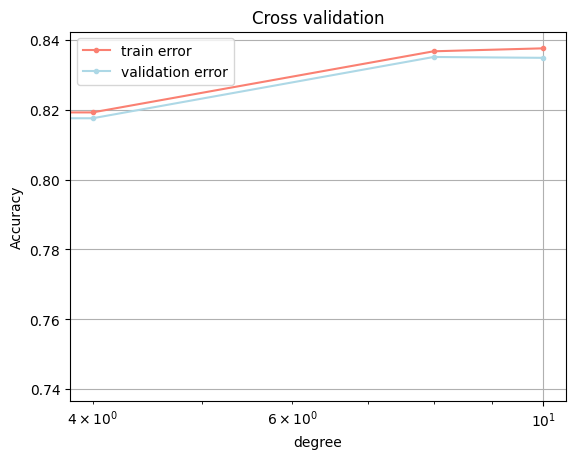

Best parameters
 {'degree': 8, 'cross': False} 

--> Test Accuracy for the best parameter :  0.8351351351351353
Ridge regression - testing lambda for degree = 1
Tested parameters

- 1 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 1e-08} 

- 2 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 1e-07} 

- 3 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 1e-06} 

- 4 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 1e-05} 

- 5 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 0.0001} 

- 6 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 0.001} 

- 7 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 0.01} 

- 8 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 0.1} 

- 9 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 1.0} 



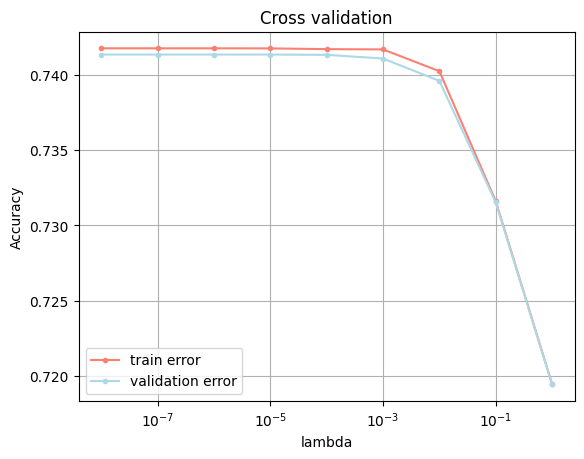

Best parameters
 {'degree': 1, 'cross': False, 'lambda_': 1e-08} 

--> Test Accuracy for the best parameter :  0.7413330623856939
Ridge regression - testing lambda for degree = 10
Tested parameters

- 1 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 1e-10} 

- 2 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 1e-09} 

- 3 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 1e-08} 

- 4 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 1e-07} 

- 5 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 1e-06} 

- 6 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 1e-05} 

- 7 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 0.0001} 

- 8 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 0.001} 

- 9 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 0.01} 

- 10 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 0.1} 

- 11 th parameter test

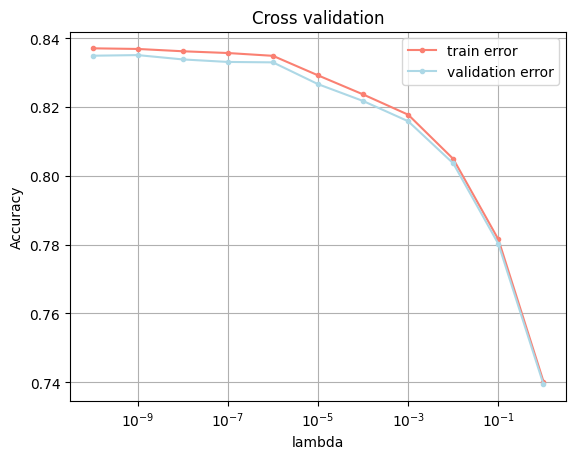

Best parameters
 {'degree': 10, 'cross': False, 'lambda_': 1e-09} 

--> Test Accuracy for the best parameter :  0.835135135135135
Least squares - testing cross term addition
Without cross terms
0.8348912822597032
With cross terms
0.8435277382645803


In [95]:
plot1_group2, plot2_group2 = make_analysis(preprocessed_X['group_2'], preprocessed_y['group_2'])

Least square - testing degrees
Tested parameters

- 1 th parameter tested :  {'degree': 0, 'cross': False} 

- 2 th parameter tested :  {'degree': 4, 'cross': False} 

- 3 th parameter tested :  {'degree': 8, 'cross': False} 

- 4 th parameter tested :  {'degree': 10, 'cross': False} 



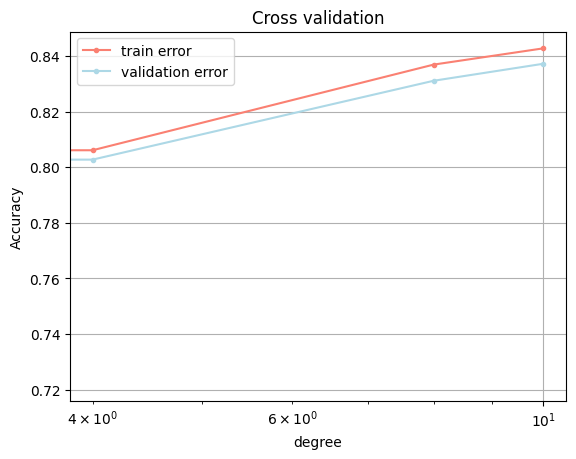

Best parameters
 {'degree': 10, 'cross': False} 

--> Test Accuracy for the best parameter :  0.8372178719484108
Ridge regression - testing lambda for degree = 1
Tested parameters

- 1 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 1e-08} 

- 2 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 1e-07} 

- 3 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 1e-06} 

- 4 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 1e-05} 

- 5 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 0.0001} 

- 6 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 0.001} 

- 7 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 0.01} 

- 8 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 0.1} 

- 9 th parameter tested :  {'degree': 1, 'cross': False, 'lambda_': 1.0} 



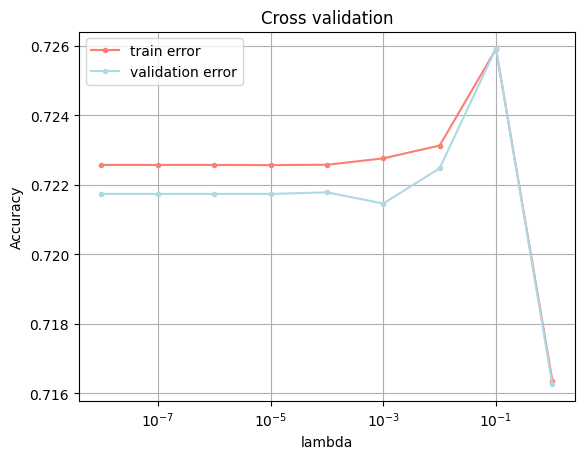

Best parameters
 {'degree': 1, 'cross': False, 'lambda_': 0.1} 

--> Test Accuracy for the best parameter :  0.7259327498848457
Ridge regression - testing lambda for degree = 10
Tested parameters

- 1 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 1e-10} 

- 2 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 1e-09} 

- 3 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 1e-08} 

- 4 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 1e-07} 

- 5 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 1e-06} 

- 6 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 1e-05} 

- 7 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 0.0001} 

- 8 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 0.001} 

- 9 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 0.01} 

- 10 th parameter tested :  {'degree': 10, 'cross': False, 'lambda_': 0.1} 

- 11 th parameter tested

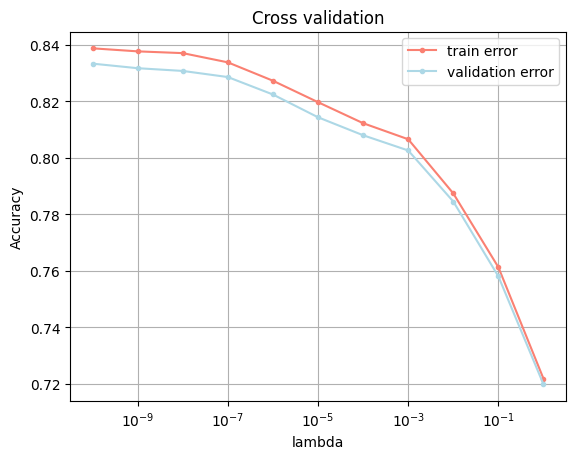

Best parameters
 {'degree': 10, 'cross': False, 'lambda_': 1e-10} 

--> Test Accuracy for the best parameter :  0.8333026255181943
Least squares - testing cross term addition
Without cross terms
0.8372178719484108
With cross terms
0.8370336250575772


In [96]:
plot1_group3, plot2_group3 = make_analysis(preprocessed_X['group_3'], preprocessed_y['group_3'])

## Plots for the report

In [125]:
import matplotlib 
matplotlib.style.use('classic')
matplotlib.rcParams.update({'font.size': 16})
dict = {}
for model in ['baseline_LS', 'degree_LS', 'degree_cross_terms_LS']:
    dict[model] = [plot1_group0[model], plot1_group1[model], plot1_group2[model], plot1_group3[model]]

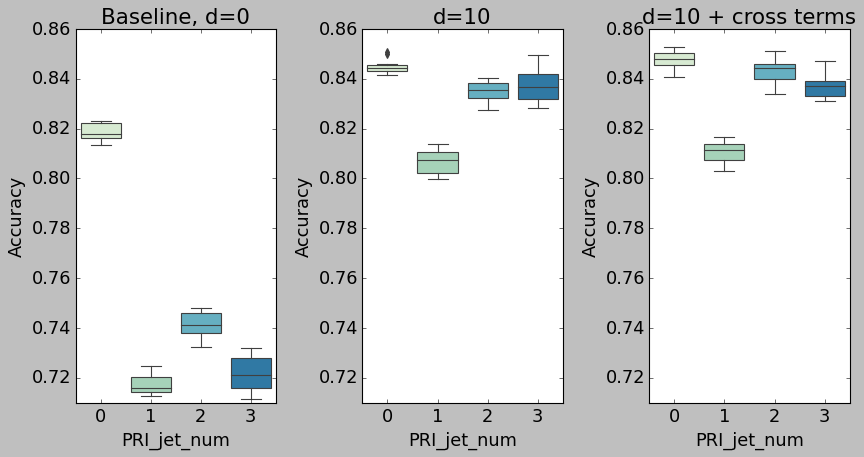

In [126]:
palette = sns.color_palette("GnBu", n_colors=4)
fig, axs = plt.subplots(1, 3, figsize=(11,6))
titles = ['Baseline, d=0', 'd=10', 'd=10 + cross terms']
idx=0   
for key, value in dict.items() :
    ax=axs[idx]
    sns.boxplot(data = dict[key], ax = ax, palette= palette)
    ax.set_xticklabels(['0', '1', '2', '3'], rotation = 0)
    ax.set_xlabel('PRI_jet_num')
    ax.set_title(titles[idx])
    ax.set_ylabel("Accuracy")
    ax.set(ylim=(0.71, 0.86))
    idx=idx+1
    
fig.tight_layout()   
plt.show()

<Figure size 640x480 with 0 Axes>

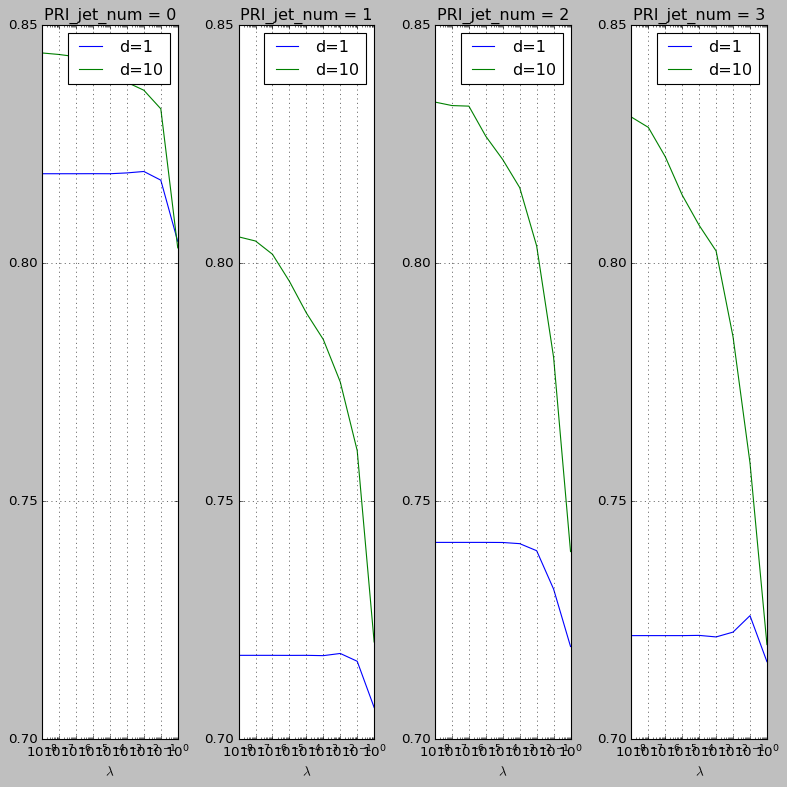

In [134]:
## Do the plot here
ylim = [.7, .85]
lambda_ = np.logspace(-8, 0, 9)
plt.figure()
matplotlib.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(nrows=1, ncols=4, sharex=True,
                                    figsize=(10, 10))
data = [plot2_group0, plot2_group1, plot2_group2, plot2_group3]
for i in range(4):
    ax[i].set_title('PRI_jet_num = {}'.format(i))
    ax[i].semilogx(lambda_, data[i]['deg_0'], label='d=1')
    ax[i].semilogx(lambda_, data[i]['deg_10'][2:], label='d=10')
    ax[i].grid(True)
    ax[i].set_ylim(ylim)
    ax[i].set_xlabel(r'$\lambda$')
    ax[i].legend()
    ax[i].locator_params(axis='y', nbins=5)

plt.tight_layout()
#plt.savefig('ridge_vs_ls.eps')